### **Importing Relevant Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import geopandas as gpd #powerful Python library built on top of Pandas designed to make working with geospatial data in Python easier
import rasterio as rio #for reading and writing geospatial raster data, specifically designed to work with formats such as GeoTIFF.

import pyogrio as pyg #Python library designed to handle geospatial data input/output operations. 
import fiona #Python library designed for reading and writing geospatial data in a variety of formats, particularly vector data formats like shapefiles, GeoJSON, and others

from geopandas import GeoDataFrame
from shapely.geometry import LineString, Point

import io

import shapely

### **1. Data Extraction & Visualization.**

### **1.1 Kenya Electricity Generation and Demand.**

In [4]:
#loading kenya electricity generation data
generation_df = pd.read_csv("..\data\electricity_generation_data\electricity-generation.csv")

#filtering to remain with kenya alone
generation_df = generation_df.query("Code=='KEN'")

#displaying first 5 rows
generation_df.head()

,Entity,Code,Year,Electricity generation - TWh
3501,Kenya,KEN,2000,4.31
3502,Kenya,KEN,2001,4.81
3503,Kenya,KEN,2002,5.15
3504,Kenya,KEN,2003,5.48
3505,Kenya,KEN,2004,6.16


In [5]:
#loading kenya electricity generation data
demand_df = pd.read_csv("..\data\electricity_generation_data\electricity-demand.csv")

#filtering to remain with kenya alone
demand_df = demand_df.query("Code=='KEN'")

#displaying first 5 rows
demand_df.head()

,Entity,Code,Year,Electricity demand - TWh
2784,Kenya,KEN,2000,4.51
2785,Kenya,KEN,2001,4.98
2786,Kenya,KEN,2002,5.37
2787,Kenya,KEN,2003,5.67
2788,Kenya,KEN,2004,6.32


### Merging Generation and Demand Datasets.

In [6]:
electricity_df = pd.merge(demand_df, generation_df, on=['Year', 'Code', 'Entity'], how='inner')
electricity_df.head()

,Entity,Code,Year,Electricity demand - TWh,Electricity generation - TWh
0,Kenya,KEN,2000,4.51,4.31
1,Kenya,KEN,2001,4.98,4.81
2,Kenya,KEN,2002,5.37,5.15
3,Kenya,KEN,2003,5.67,5.48
4,Kenya,KEN,2004,6.32,6.16


### Visualizing Merged Generation and Demand Datasets

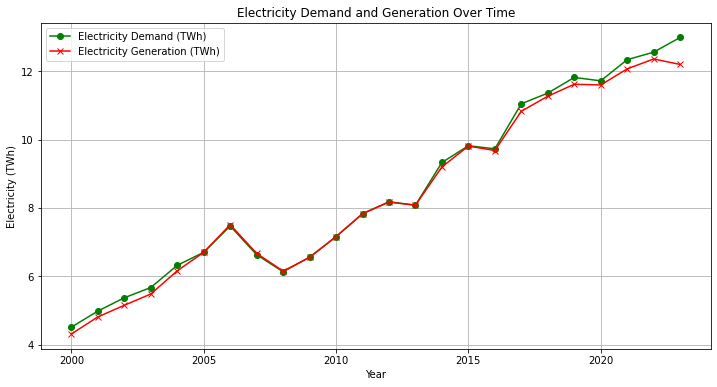

In [7]:
# Extract the relevant columns for plotting
years_demand =demand_df['Year']
demand_values = demand_df['Electricity demand - TWh']

years_generation = generation_df['Year']
generation_values = generation_df['Electricity generation - TWh']

# Plotting demand and generation over time
plt.figure(figsize=(12, 6))
plt.plot(years_demand, demand_values, label='Electricity Demand (TWh)', color='green', marker='o')
plt.plot(years_generation, generation_values, label='Electricity Generation (TWh)', color='red', marker='x')

# Adding title and labels
plt.title('Electricity Demand and Generation Over Time')
plt.xlabel('Year')
plt.ylabel('Electricity (TWh)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### **1.2 Renewable Potential.**

### Kenya Windspeed

In [8]:
import rasterio

file_path = r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\renewable_potential_data\kenya_renewable_data\kenya_wind-speed_100m.tif'
# Open the .tif file using rasterio
with rasterio.open(file_path) as src:
    raster_data = src.read(1)  # Read the first band
    profile = src.profile     # Get metadata for the file

profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4149, 'height': 3806, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002500000000000124, 0.0, 33.906572682195275,
       0.0, -0.002500000000000124, 4.623268747733392), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [9]:
# Get NoData value from the metadata
nodata_value = profile.get('nodata', -9999)

# Find and count NoData values in the array
nodata_count = np.sum(raster_data == nodata_value)
print(f"NoData values count: {nodata_count}")

NoData values count: 0


In [10]:
# Open the TIFF file
with rasterio.open(r'C:\Users\User\Energy-Access-and-Electrification-planning-in-Kenya\data\renewable_potential_data\kenya_renewable_data\kenya_wind-speed_100m.tif') as src:
    # Print metadata
    print("Metadata:", src.meta)
    
    # Print dimensions (height and width) and number of bands
    print("Dimensions (Height x Width):", src.height, "x", src.width)
    print("Number of Bands:", src.count)
    
    # Print coordinate reference system (CRS)
    print("Coordinate Reference System (CRS):", src.crs)
    
    # Print affine transformation (mapping coordinates to array indices)
    print("Affine Transformation:", src.transform)

    # Read the first band and print a portion of pixel values as an example
    band1 = src.read(1)  # Read the first band
    print("Sample Pixel Values (Top-left corner):\n", band1[:5, :5])

Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4149, 'height': 3806, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002500000000000124, 0.0, 33.906572682195275,
       0.0, -0.002500000000000124, 4.623268747733392)}
Dimensions (Height x Width): 3806 x 4149
Number of Bands: 1
Coordinate Reference System (CRS): EPSG:4326
Affine Transformation: | 0.00, 0.00, 33.91|
| 0.00,-0.00, 4.62|
| 0.00, 0.00, 1.00|
Sample Pixel Values (Top-left corner):
 [[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


In [11]:
# Check the no data value
no_data_value = src.nodata

# Create a mask for the no data values
masked_data = np.ma.masked_equal(raster_data, no_data_value)

In [12]:
# Calculate statistics
mean_speed = np.mean(masked_data)
median_speed = np.median(masked_data)
std_dev_speed = np.std(masked_data)

print(f'Mean Wind Speed: {mean_speed:.2f} m/s')
print(f'Median Wind Speed: {median_speed:.2f} m/s')
print(f'Standard Deviation: {std_dev_speed:.2f} m/s')

Mean Wind Speed: nan m/s
Median Wind Speed: nan m/s
Standard Deviation: -- m/s


c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
<ipython-input-12-d9d7f818602f>:8: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f'Standard Deviation: {std_dev_speed:.2f} m/s')


### Visualizing the Windspeed Data

#### Use matplotlib to visualize the wind speed:

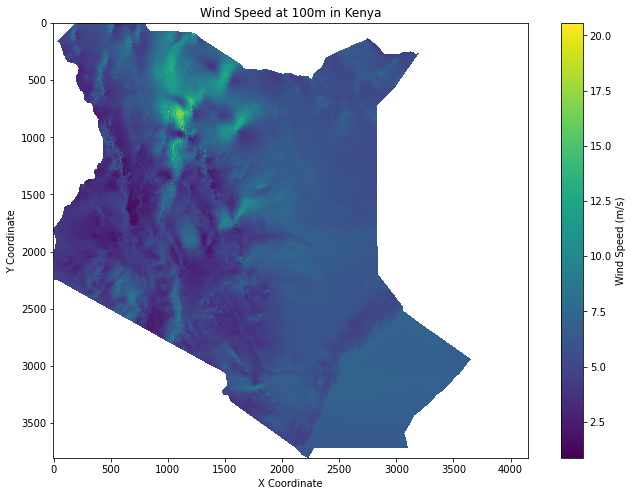

In [13]:
plt.figure(figsize=(12, 8))
plt.title('Wind Speed at 100m in Kenya')
plt.imshow(masked_data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Wind Speed (m/s)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(False)
plt.show()

### Histograms of Windspeed:
#### Visualizing the distribution of wind speeds can be helpful.

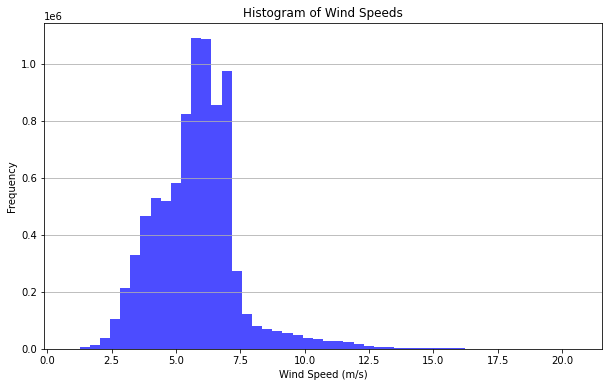

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(masked_data.compressed(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Wind Speeds')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

###  Identifying High Wind Speed Areas
#### You can identify areas with high average wind speeds, which may be potential sites for wind energy development:

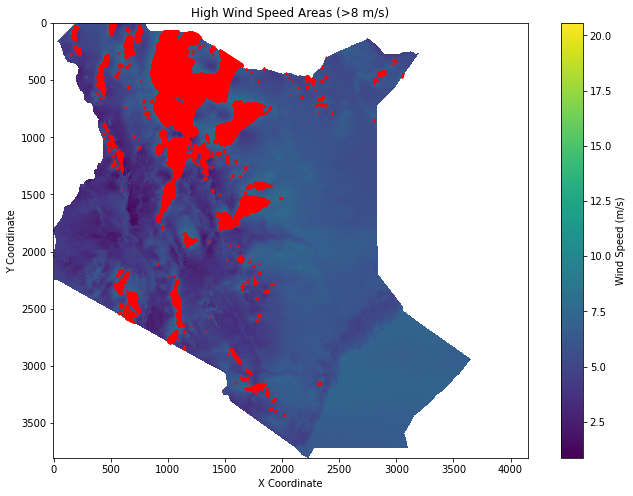

In [15]:
# Define a threshold for high wind speed
high_wind_threshold = 8  # m/s, adjust based on your criteria
high_wind_areas = np.where(masked_data > high_wind_threshold)

# Plot high wind areas
plt.figure(figsize=(12, 8))
plt.imshow(masked_data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Wind Speed (m/s)')
plt.scatter(high_wind_areas[1], high_wind_areas[0], color='red', s=1)  # s is the size of points
plt.title('High Wind Speed Areas (>8 m/s)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(False)
plt.show()

In [16]:
# Load the wind TIFF file
wind_speed = r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\renewable_potential_data\kenya_renewable_data\kenya_wind-speed_100m.tif'
with rasterio.open(wind_speed) as src:
    # Read the wind speed data from the first band
    wind_data = src.read(1)
    transform = src.transform

# List to store latitude, longitude, and wind speed values
data = []

# Loop over each pixel
for row in range(wind_data.shape[0]):
    for col in range(wind_data.shape[1]):
        # Convert row, col to latitude, longitude
        lon, lat = rasterio.transform.xy(transform, row, col)
        wind_speed = wind_data[row, col]

        # Append to data list if wind speed is valid (not a nodata value)
        if not np.isnan(wind_speed):
            data.append({'Latitude': lat, 'Longitude': lon, 'Wind Speed': wind_speed})

wind_speed_df = pd.DataFrame(data)
print(wind_speed_df)

         Latitude  Longitude  Wind Speed
0        4.622019  35.915323    6.276936
1        4.622019  35.917823    6.260634
2        4.622019  35.920323    6.232945
3        4.622019  35.922823    6.241162
4        4.622019  35.925323    6.216225
...           ...        ...         ...
8538058 -4.887981  39.480323    6.142080
8538059 -4.890481  39.472823    6.143734
8538060 -4.890481  39.475323    6.142651
8538061 -4.890481  39.477823    6.141578
8538062 -4.890481  39.480323    6.140533

[8538063 rows x 3 columns]


### **1.3 Kenya Population Density.**

In [17]:
# Kenya's population density: 2000
pop_density2000 = gpd.read_file(r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\pop_density_data\pop_density_data\2000.csv', engine='pyogrio')
pop_density2000 = pop_density2000.astype({
    'X':float,
    'Y':float,
    'Z':float})

# Kenya's population density: 2020
pop_density2020 = gpd.read_file(r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\pop_density_data\pop_density_data\2020.csv', engine='pyogrio')
pop_density2020 = pop_density2020.astype({
    'X':float,
    'Y':float,
    'Z':float})


print('Kenyas Population Density: 2000', pop_density2000.head())

print('Kenyas Population Density: 2020', pop_density2020.head())


Kenyas Population Density: 2000            X         Y         Z
0  35.244583  5.462084  1.416720
1  35.252917  5.462084  1.413419
2  35.261250  5.462084  1.418887
3  35.269583  5.462084  1.457395
4  35.277917  5.462084  1.512301
Kenyas Population Density: 2020            X         Y          Z
0  35.244583  5.462084  52.668011
1  35.252917  5.462084  42.566807
2  35.261250  5.462084  39.304050
3  35.269583  5.462084  41.851067
4  35.277917  5.462084  38.238289


In [18]:
# 2000 Geometry
pop_density2000 = gpd.GeoDataFrame(
    pop_density2000, geometry=gpd.points_from_xy(pop_density2000.X, pop_density2000.Y), crs="EPSG:4326"
).drop(columns=['X','Y']).rename(columns={'Z':'Density'})

# 2020 Geometry
pop_density2020 = gpd.GeoDataFrame(
    pop_density2020, geometry=gpd.points_from_xy(pop_density2020.X, pop_density2020.Y), crs="EPSG:4326"
).drop(columns=['X','Y']).rename(columns={'Z':'Density'})


print('Kenyas Population Density Geometry: 2000', pop_density2020.head())
print('Kenyas Population Density Geometry: 2020', pop_density2000.head())

Kenyas Population Density Geometry: 2000      Density                  geometry
0  52.668011  POINT (35.24458 5.46208)
1  42.566807  POINT (35.25292 5.46208)
2  39.304050  POINT (35.26125 5.46208)
3  41.851067  POINT (35.26958 5.46208)
4  38.238289  POINT (35.27792 5.46208)
Kenyas Population Density Geometry: 2020     Density                  geometry
0  1.416720  POINT (35.24458 5.46208)
1  1.413419  POINT (35.25292 5.46208)
2  1.418887  POINT (35.26125 5.46208)
3  1.457395  POINT (35.26958 5.46208)
4  1.512301  POINT (35.27792 5.46208)


In [19]:
desc_pop_density2000 = pop_density2000.Density.describe(percentiles=[.95])
print('Kenyas Population Density Decription: 2000', desc_pop_density2000)

desc_pop_density2020 = pop_density2020.Density.describe(percentiles=[.95])
print('Kenyas Population Density Decription: 2020', desc_pop_density2020)

Kenyas Population Density Decription: 2000 count    680385.000000
mean         50.927232
std         320.932973
min           0.000000
50%           4.618363
95%         259.467688
max       73272.679688
Name: Density, dtype: float64
Kenyas Population Density Decription: 2020 count    680262.000000
mean         95.214693
std         661.822734
min           0.000000
50%          12.548709
95%         438.835638
max      167454.390625
Name: Density, dtype: float64


In [20]:
ke_counties = gpd.read_file(r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\income_level_data\GSAP_AM24_2021.shp', engine='pyogrio',
                                   where="code='KEN'")

ke_counties.head()

,code,geo_year,geo_source,geo_level,geo_idvar,geo_id,geo_nvar,geo_name,geo_code,geometry
0,KEN,2022.0,GADM,1,GID_1,KEN.1_1,NAME_1,Baringo,KEN_2022_GADM1_KEN.1_1,"MULTIPOLYGON (((35.73880 -0.19544, 35.72428 -0..."
1,KEN,2022.0,GADM,1,GID_1,KEN.2_1,NAME_1,Bomet,KEN_2022_GADM1_KEN.2_1,"POLYGON ((35.26033 -1.01608, 35.26021 -1.01621..."
2,KEN,2022.0,GADM,1,GID_1,KEN.3_1,NAME_1,Bungoma,KEN_2022_GADM1_KEN.3_1,"POLYGON ((34.91305 0.85131, 34.91327 0.85148, ..."
3,KEN,2022.0,GADM,1,GID_1,KEN.4_1,NAME_1,Busia,KEN_2022_GADM1_KEN.4_1,"POLYGON ((34.02698 -0.01568, 34.02082 -0.02018..."
4,KEN,2022.0,GADM,1,GID_1,KEN.5_1,NAME_1,Elgeyo-Marakwet,KEN_2022_GADM1_KEN.5_1,"MULTIPOLYGON (((35.53068 0.22495, 35.53475 0.2..."


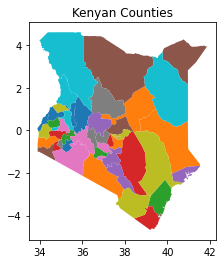

In [21]:
import matplotlib.pyplot as plt

ax = ke_counties.plot(column='geo_name')
ax.set_title("Kenyan Counties")
plt.show()

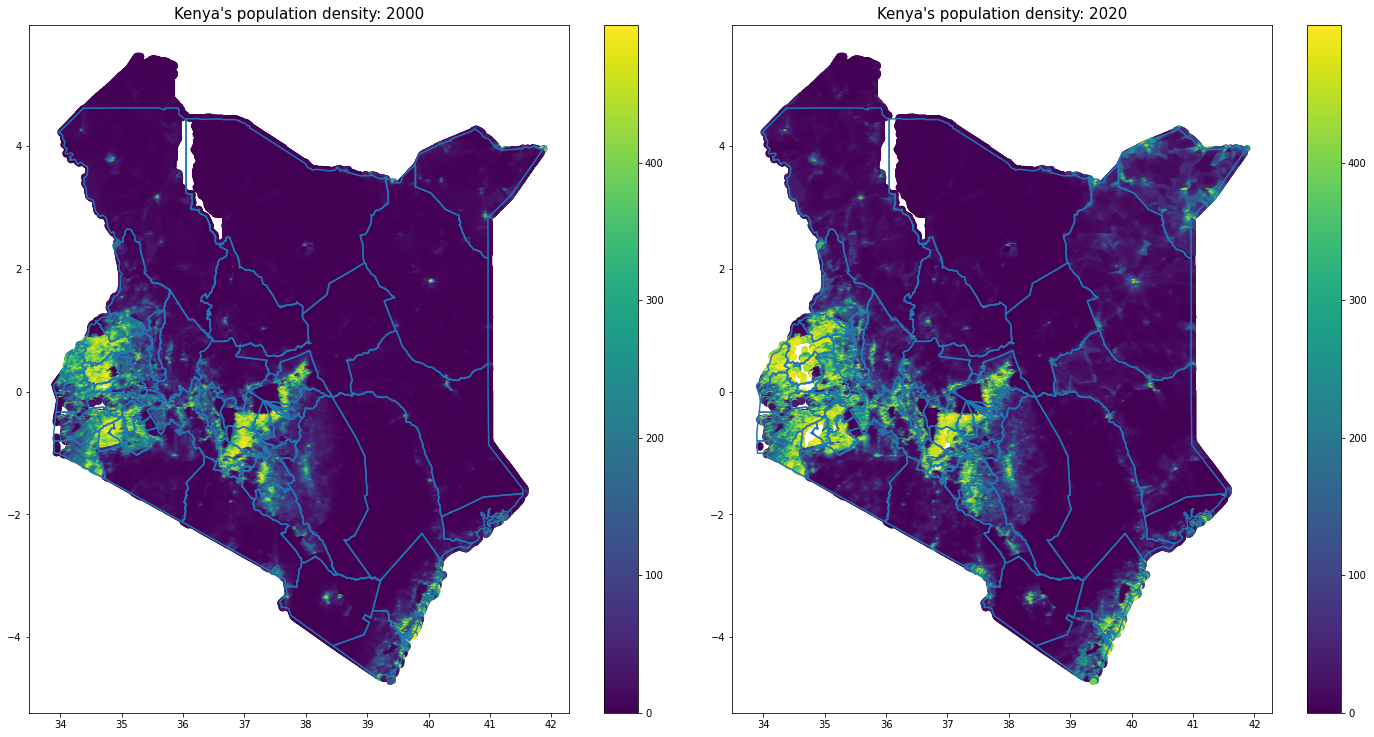

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Kenya's population density: 2000
base1 = ke_counties.boundary.plot(ax=axes[0])
pop_density2000.query('Density < 500').plot(ax=base1, column='Density', legend=True)
axes[0].set_title("Kenya's population density: 2000", fontsize=15)

# Kenya's population density: 2020
base2 = ke_counties.boundary.plot(ax=axes[1])
pop_density2020.query('Density < 500').plot(ax=base2, column='Density', legend=True)
axes[1].set_title("Kenya's population density: 2020", fontsize=15)

plt.tight_layout()
plt.show()

In [23]:
import glob
import os

# Define the path to your CSV files
path = r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\pop_density_data\pop_density_data'
pop_files = glob.glob(path + "/*.csv")

# Initialize a list to hold each DataFrame
pop_dfs = []

# Loop over each file to process it
for file in pop_files:
    year = os.path.basename(file).split('.')[0]
    pop_df = pd.read_csv(file)
    pop_df = pop_df.rename(columns={'Z': year, 'X':'Latitude', 'Y':'Longitude'})

    # Append the DataFrame to the list
    pop_dfs.append(pop_df)

# Merge all DataFrames on 'X' and 'Y' columns
pop_density_df = pop_dfs[0]
for pop_df in pop_dfs[1:]:
    pop_density_df = pop_density_df.merge(pop_df, on=['Latitude', 'Longitude'], how='outer')

pop_density_df

,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,7.716132,10.052105,11.457187,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,7.106965,8.990801,10.381531,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,6.575239,8.322875,9.466146,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,6.775673,8.556246,9.631298,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,6.441066,7.914247,9.031144,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680380,39.402917,-4.704583,126.856934,114.480789,92.233864,51.968880,38.705093,36.720055,32.964993,33.610413,...,41.805164,38.985413,81.165375,39.789425,75.514580,152.778000,154.110641,143.955246,149.165466,166.426895
680381,39.411250,-4.704583,172.707367,150.494247,120.754379,74.849098,54.277927,52.671711,47.649155,47.568836,...,60.505344,56.823631,107.771729,59.105076,106.717369,199.424561,185.219086,184.364685,194.443283,205.901260
680382,39.369583,-4.712916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
680383,39.377917,-4.712916,67.794678,17.083441,15.369174,15.428894,11.420929,13.993786,11.441626,10.612007,...,12.901483,13.024007,16.545351,13.038383,17.950626,173.214050,202.145950,170.369278,181.272644,208.989548


In [24]:
pop_density_df.isna().sum()

Latitude         0
Longitude        0
2000             0
2001           123
2002           123
2003           123
2004           123
2005           123
2006           123
2007           123
2008           123
2009           123
2010           123
2011           123
2012         15620
2013           123
2014           123
2015           123
2016           123
2017           123
2018           123
2019           123
2020           123
dtype: int64

In [25]:
desc = pop_density_df.describe()

pop_density_df_median = pop_density_df.median()
pop_density_df_mode = pop_density_df.mode().iloc[0]

# Add median and mode to the summary statistics
desc.loc['median'] = pop_density_df_median
desc.loc['mode'] = pop_density_df_mode

desc

,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,680385.000000,680385.000000,680385.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,...,680262.000000,664765.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000,680262.000000
mean,37.861907,0.573581,50.927232,52.459902,54.000005,55.613002,57.289448,59.018250,60.824189,62.662968,...,70.889556,74.859941,75.513673,77.967967,80.553650,83.250692,86.040443,88.969168,92.033193,95.214693
std,1.913418,2.243391,320.932973,338.698894,349.132566,361.373502,374.837981,387.024269,401.239046,414.478211,...,476.480483,502.057518,512.381152,536.079582,553.170439,573.424865,593.883451,615.075237,637.065595,661.822734
min,33.911250,-4.721250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.252917,-1.179583,1.313963,1.213779,1.243484,1.267215,1.248924,1.305102,1.379348,1.426990,...,1.699221,1.967763,1.987099,1.819858,2.170963,2.202294,2.339124,2.448167,2.578045,2.688723
50%,37.961250,0.545417,4.618363,4.307683,4.510057,4.749110,4.849887,5.124676,5.464599,5.723913,...,7.065644,7.878909,8.322715,8.067155,9.381569,9.787829,10.520063,11.184121,11.858059,12.548709
75%,39.461250,2.437084,19.172338,18.049306,18.899896,19.815576,19.939114,21.113575,22.152358,23.193607,...,27.750169,30.622528,32.024692,31.613075,35.249906,39.111917,41.275894,43.627444,45.831752,48.195143
max,41.877917,5.462084,73272.679688,78880.398438,82250.742188,87578.140625,90830.289062,95338.015625,98978.320312,102166.289062,...,117108.632812,123729.703125,129937.796875,134740.765625,139931.328125,145386.234375,151110.140625,156010.750000,162006.625000,167454.390625
median,37.961250,0.545417,4.618363,4.307683,4.510057,4.749110,4.849887,5.124676,5.464599,5.723913,...,7.065644,7.878909,8.322715,8.067155,9.381569,9.787829,10.520063,11.184121,11.858059,12.548709
mode,39.219583,-1.012916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.820851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
# Fill na with the modal values
pop_density_df = pop_density_df.fillna(pop_density_df.mode().iloc[0])
pop_density_df.isna().sum()

Latitude     0
Longitude    0
2000         0
2001         0
2002         0
2003         0
2004         0
2005         0
2006         0
2007         0
2008         0
2009         0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
2020         0
dtype: int64

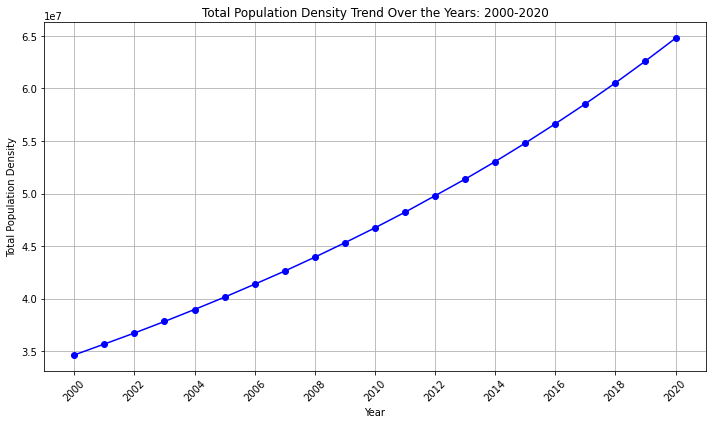

In [27]:
# Total population density per year
year_columns = pop_density_df.columns[2:]
annual_total_density = pop_density_df[year_columns].sum()

# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(annual_total_density.index, annual_total_density.values, marker='o', color='b')
plt.xlabel("Year")
plt.ylabel("Total Population Density")
plt.title("Total Population Density Trend Over the Years: 2000-2020")
plt.grid(True)
plt.xticks(ticks=annual_total_density.index[::2], rotation=45)

plt.tight_layout()
plt.show()

### **1.4 Kenya Income Level Data.**

In [28]:
shp_file_path = r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\income_level_data\GSAP_AM24_2021.shp'
gdf = gpd.read_file(shp_file_path, engine='pyogrio')

print(gdf.shape)
gdf.head()

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\income_level_data\GSAP_AM24_2021.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


(1835, 10)


,code,geo_year,geo_source,geo_level,geo_idvar,geo_id,geo_nvar,geo_name,geo_code,geometry
0,ABW,NaN,None,None,None,None,None,Aruba (Neth.),ABW_2020_WB0,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,NaN,None,None,None,None,None,Afghanistan,AFG_2020_WB0,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
2,AGO,2015.0,GAUL,1,ADM1_CODE,398,ADM1_NAME,Bengo,AGO_2015_GAUL1_398,"POLYGON ((13.14401 -9.33313, 13.14405 -9.33316..."
3,AGO,2015.0,GAUL,1,ADM1_CODE,399,ADM1_NAME,Benguela,AGO_2015_GAUL1_399,"POLYGON ((13.79886 -11.77102, 13.79883 -11.771..."
4,AGO,2015.0,GAUL,1,ADM1_CODE,400,ADM1_NAME,Bie,AGO_2015_GAUL1_400,"POLYGON ((16.79741 -10.77021, 16.80907 -10.772..."


In [29]:
kenya_income_level = gdf[gdf['code'] == 'KEN']

print(kenya_income_level.shape)
kenya_income_level.head()

(47, 10)


,code,geo_year,geo_source,geo_level,geo_idvar,geo_id,geo_nvar,geo_name,geo_code,geometry
679,KEN,2022.0,GADM,1,GID_1,KEN.1_1,NAME_1,Baringo,KEN_2022_GADM1_KEN.1_1,"MULTIPOLYGON (((35.73880 -0.19544, 35.72428 -0..."
680,KEN,2022.0,GADM,1,GID_1,KEN.2_1,NAME_1,Bomet,KEN_2022_GADM1_KEN.2_1,"POLYGON ((35.26033 -1.01608, 35.26021 -1.01621..."
681,KEN,2022.0,GADM,1,GID_1,KEN.3_1,NAME_1,Bungoma,KEN_2022_GADM1_KEN.3_1,"POLYGON ((34.91305 0.85131, 34.91327 0.85148, ..."
682,KEN,2022.0,GADM,1,GID_1,KEN.4_1,NAME_1,Busia,KEN_2022_GADM1_KEN.4_1,"POLYGON ((34.02698 -0.01568, 34.02082 -0.02018..."
683,KEN,2022.0,GADM,1,GID_1,KEN.5_1,NAME_1,Elgeyo-Marakwet,KEN_2022_GADM1_KEN.5_1,"MULTIPOLYGON (((35.53068 0.22495, 35.53475 0.2..."


In [30]:
# Create an empty list to store the results
rows = []

# Iterate through each geometry and extract latitude and longitude
for index, row in kenya_income_level.iterrows():
    # Extract the geometry
    geom = row['geometry']

    # Handle MULTIPOLYGON or POLYGON types
    if geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms:  # Use geom.geoms to access individual polygons
            for coord in polygon.exterior.coords:
                rows.append({
                    'County': row['geo_name'],
                    'Latitude': coord[1],
                    'Longitude': coord[0]
                })
    elif geom.geom_type == 'Polygon':
        for coord in geom.exterior.coords:
            rows.append({
                'Latitude': coord[1],
                'Longitude': coord[0],
                'County': row['geo_name']
            })

kenya_income_level = pd.DataFrame(rows)
print(kenya_income_level.shape)
kenya_income_level

(274900, 3)


,County,Latitude,Longitude
0,Baringo,-0.195439,35.738800
1,Baringo,-0.198901,35.724277
2,Baringo,-0.195616,35.723232
3,Baringo,-0.195289,35.723129
4,Baringo,-0.194905,35.723007
...,...,...,...
274895,West Pokot,1.190623,35.422623
274896,West Pokot,1.189342,35.422203
274897,West Pokot,1.188469,35.422005
274898,West Pokot,1.187765,35.421890


In [31]:
print(kenya_income_level.County.nunique())
kenya_income_level.County.unique()

47


array(['Baringo', 'Bomet', 'Bungoma', 'Busia', 'Elgeyo-Marakwet', 'Embu',
       'Garissa', 'Homa Bay', 'Isiolo', 'Kajiado', 'Kakamega', 'Kericho',
       'Kiambu', 'Kilifi', 'Kirinyaga', 'Kisii', 'Kisumu', 'Kitui',
       'Kwale', 'Laikipia', 'Lamu', 'Machakos', 'Makueni', 'Mandera',
       'Marsabit', 'Meru', 'Migori', 'Mombasa', "Murang'a", 'Nairobi',
       'Nakuru', 'Nandi', 'Narok', 'Nyamira', 'Nyandarua', 'Nyeri',
       'Samburu', 'Siaya', 'Taita Taveta', 'Tana River', 'Tharaka-Nithi',
       'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'Vihiga', 'Wajir',
       'West Pokot'], dtype=object)

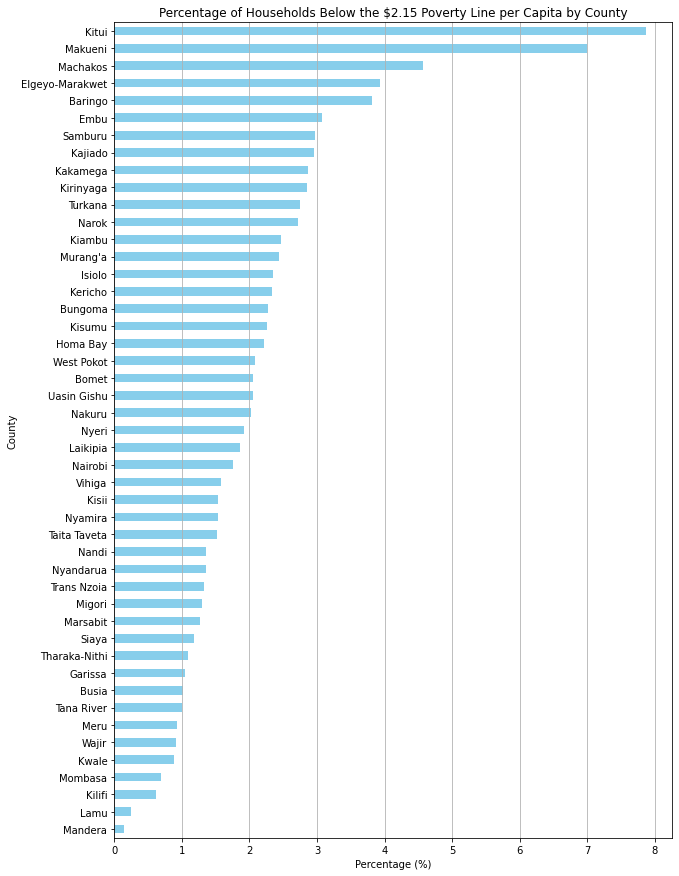

In [32]:
# Count occurrences of each county
county_counts = kenya_income_level['County'].value_counts()

# Calculate the percentage of each county
county_percentage = (county_counts / county_counts.sum()) * 100
county_percentage = county_percentage.sort_values(ascending=True)

# Plotting the horizontal bar graph
plt.figure(figsize=(10, 15))
county_percentage.plot(kind='barh', color='skyblue')

# Adding titles and labels
plt.title('Percentage of Households Below the $2.15 Poverty Line per Capita by County')
plt.xlabel('Percentage (%)')
plt.ylabel('County')

# Show the plot
plt.grid(axis='x')
plt.show()

### **1.5 Grid Infrastrucure Data.**

In [33]:
# Define file path
file_path = r"C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\grid_infrustructure_data\global_data\global_1_1_1_1_1_0.tif"
#file_path = r'C:\Users\User\Documents\Energy-Access-and-Electrification-planning\data\grid_infrustructure_data\global_data\global_1_1_1_1_1_0.tif'

# Open the .tif file using rasterio
with rio.open(file_path) as src:
    raster_data = src.read(1)  # Read the first band
    profile = src.profile # Get metadata for the file
    #print(raster_data)    
    print(profile) 

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 24527, 'height': 8674, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.009999999999999998, 0.0, -89.335692917,
       0.0, -0.01, 51.90425168), 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


In [34]:
from rasterio.plot import show

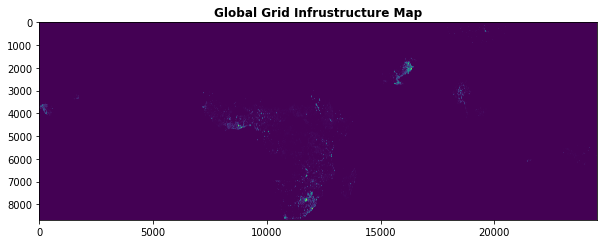

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the raster data
show(raster_data, ax=ax, title="Global Grid Infrustructure Map")

plt.show()

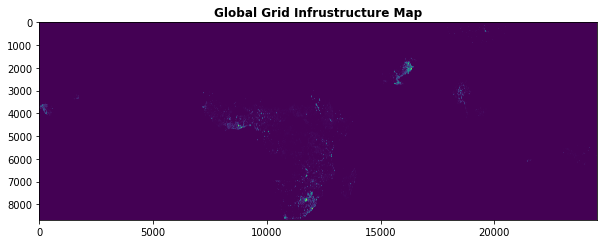

In [36]:
# Open the .tif raster file
with rasterio.open(r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\grid_infrustructure_data\global_data\global_1_1_1_1_1_0.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the raster data
    show(raster_data, ax=ax, title="Global Grid Infrustructure Map")

plt.show()

In [37]:
# Path to the TIFF file
tiff_path = r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\grid_infrustructure_data\global_data\global_1_1_1_1_1_0.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    
    grid_array = src.read(1) 
    transform = src.transform
    width, height = src.width, src.height

    # Lists to store the results
    latitudes = []
    longitudes = []
    grid_values = []

    # Loop through each pixel to get its coordinate and value
    for row in range(height):
        for col in range(width):
            # Get the grid value at the current pixel
            grid_value = grid_array[row, col]

            # Ignore nodata values
            if grid_value == src.nodata:
                continue

            # Convert row, col to latitude, longitude
            lon, lat = rasterio.transform.xy(transform, row, col, offset='center')

            # Append to lists
            latitudes.append(lat)
            longitudes.append(lon)
            grid_values.append(grid_value)

# Create a DataFrame
grid_df = pd.DataFrame({
    "Latitude": latitudes,
    "Longitude": longitudes,
    "GridValue": grid_values
})

grid_df

,Latitude,Longitude,GridValue
0,51.899252,99.259307,7
1,51.689252,99.309307,3
2,51.669252,99.319307,5
3,51.659252,100.529307,3
4,51.639252,100.859307,5
...,...,...,...
4235274,-34.820748,20.059307,98
4235275,-34.830748,19.999307,1
4235276,-34.830748,20.009307,1
4235277,-34.830748,20.019307,1


In [38]:
# Extract Kenya's coordinates
import pandas as pd

kenya_grid_df = grid_df[(grid_df['Latitude'] >= -4.7) & (grid_df['Latitude'] <= 5.1) &
              (grid_df['Longitude'] >= 33.5) & (grid_df['Longitude'] <= 41.9)]

print(kenya_grid_df.isna().sum())
kenya_grid_df 

Latitude     0
Longitude    0
GridValue    0
dtype: int64


,Latitude,Longitude,GridValue
2410365,5.099252,33.529307,1
2410366,5.099252,33.539307,1
2410367,5.099252,36.089307,1
2410368,5.099252,36.389307,3
2410369,5.099252,36.469307,3
...,...,...,...
3023566,-4.690748,39.109307,1
3023567,-4.690748,39.129307,1
3023568,-4.690748,39.139307,3
3023569,-4.690748,39.149307,3


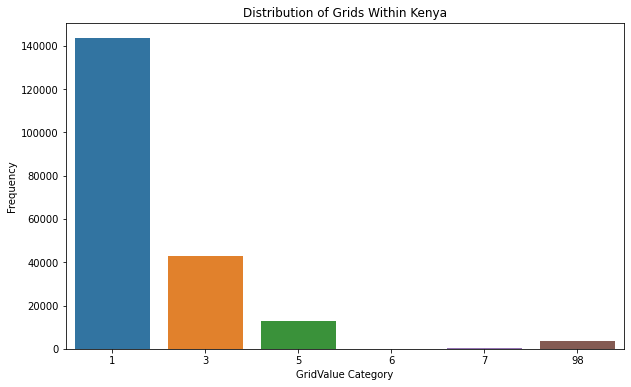

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=kenya_grid_df, x='GridValue')
plt.title("Distribution of Grids Within Kenya")
plt.xlabel("GridValue Category")
plt.ylabel("Frequency")
plt.show()


<Figure size 864x576 with 0 Axes>

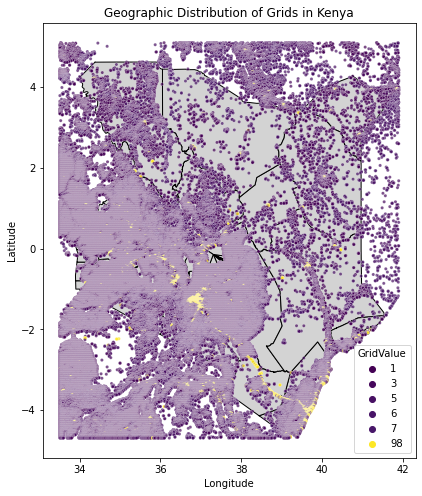

In [40]:
kenya_shapefile = gpd.read_file(r'C:\Users\User\Desktop\CAPSTONE\Energy-Access-and-Electrification-planning-in-Kenya\data\income_level_data\GSAP_AM24_2021.shp',
                                engine='pyogrio',
                                   where="code='KEN'")


# Scatter plot of grid values
plt.figure(figsize=(12, 8))

# Kenya boundary first on the background
ax = kenya_shapefile.plot(figsize=(12, 8), color='lightgrey', edgecolor='black')

# Plot the scatter plot of your grid values
sns.scatterplot(data=kenya_grid_df, x='Longitude', y='Latitude', hue='GridValue', palette='viridis', s=10, alpha=0.7, ax=ax)


plt.title("Geographic Distribution of Grids in Kenya")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="GridValue")

plt.show()

### **2. Datasets Merging.**

In [41]:
# Electricity generation and demand df
print(electricity_df.shape)
electricity_df.head()

(24, 5)


,Entity,Code,Year,Electricity demand - TWh,Electricity generation - TWh
0,Kenya,KEN,2000,4.51,4.31
1,Kenya,KEN,2001,4.98,4.81
2,Kenya,KEN,2002,5.37,5.15
3,Kenya,KEN,2003,5.67,5.48
4,Kenya,KEN,2004,6.32,6.16


In [42]:
# Windspeed df
print(wind_speed_df.shape)
print(wind_speed_df.isna().sum())
wind_speed_df.head()

(8538063, 3)
Latitude      0
Longitude     0
Wind Speed    0
dtype: int64


,Latitude,Longitude,Wind Speed
0,4.622019,35.915323,6.276936
1,4.622019,35.917823,6.260634
2,4.622019,35.920323,6.232945
3,4.622019,35.922823,6.241162
4,4.622019,35.925323,6.216225


In [43]:
# Population density df
print(pop_density_df.shape)
print(pop_density_df.isna().sum())
pop_density_df.head()

(680385, 23)
Latitude     0
Longitude    0
2000         0
2001         0
2002         0
2003         0
2004         0
2005         0
2006         0
2007         0
2008         0
2009         0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
2020         0
dtype: int64


,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,7.716132,10.052105,11.457187,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,7.106965,8.990801,10.381531,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,6.575239,8.322875,9.466146,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,6.775673,8.556246,9.631298,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,6.441066,7.914247,9.031144,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289


In [44]:
# Income level df
income_level_df = kenya_income_level

print(income_level_df.shape)
print(income_level_df.isna().sum())
income_level_df.head()

(274900, 3)
County       0
Latitude     0
Longitude    0
dtype: int64


,County,Latitude,Longitude
0,Baringo,-0.195439,35.738800
1,Baringo,-0.198901,35.724277
2,Baringo,-0.195616,35.723232
3,Baringo,-0.195289,35.723129
4,Baringo,-0.194905,35.723007


In [45]:
# Grid infrastructure df
kenya_grid_df = kenya_grid_df.reset_index(drop = True)

print(kenya_grid_df.shape)
print(kenya_grid_df.isna().sum())
kenya_grid_df.head()

(203255, 3)
Latitude     0
Longitude    0
GridValue    0
dtype: int64


,Latitude,Longitude,GridValue
0,5.099252,33.529307,1
1,5.099252,33.539307,1
2,5.099252,36.089307,1
3,5.099252,36.389307,3
4,5.099252,36.469307,3


In [46]:
# Merging population density and wind speed data
merged_df = pd.merge(pop_density_df, wind_speed_df, on=['Latitude', 'Longitude'], how='outer')
merged_df.head()

,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Wind Speed
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,10.052105,11.457187,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,8.990801,10.381531,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,8.322875,9.466146,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,8.556246,9.631298,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,7.914247,9.031144,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN


In [47]:
merged_df.shape

(9218448, 24)

In [48]:
# Adding grid infrastructure data
merged_df = pd.merge(merged_df, kenya_grid_df, on=['Latitude', 'Longitude'], how='outer')
print(merged_df.shape)
merged_df.head()

(9421703, 25)


,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,Wind Speed,GridValue
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,11.457187,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN,NaN
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,10.381531,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN,NaN
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,9.466146,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN,NaN
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,9.631298,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN,NaN
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,9.031144,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN,NaN


In [49]:
# Adding income level data by county
merged_df = pd.merge(merged_df, income_level_df, on=['Latitude', 'Longitude'], how='outer')

print(merged_df.shape)
print(merged_df.isna().sum())
merged_df.head()

(9696603, 26)
Latitude            0
Longitude           0
2000          9016218
2001          9016218
2002          9016218
2003          9016218
2004          9016218
2005          9016218
2006          9016218
2007          9016218
2008          9016218
2009          9016218
2010          9016218
2011          9016218
2012          9016218
2013          9016218
2014          9016218
2015          9016218
2016          9016218
2017          9016218
2018          9016218
2019          9016218
2020          9016218
Wind Speed    1158540
GridValue     9493348
County        9421703
dtype: int64


,Latitude,Longitude,2000,2001,2002,2003,2004,2005,2006,2007,...,2014,2015,2016,2017,2018,2019,2020,Wind Speed,GridValue,County
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN,NaN,NaN
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN,NaN,NaN
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN,NaN,NaN
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN,NaN,NaN
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN,NaN,NaN


In [50]:
# Rename columns
merged_df.columns = ['Latitude', 'Longitude'] + [f'Pop_Density_{year}' for year in range(2000, 2021)] + ['Wind_Speed', 'Grid_Value', 'Income_Distribution']
merged_df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN,NaN,NaN
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN,NaN,NaN
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN,NaN,NaN
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN,NaN,NaN
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN,NaN,NaN


### **3. Filling Null Values.**

#### **3.1 Income Level**

In [51]:
from sklearn.neighbors import BallTree

# Extract latitude and longitude for both dataframes
merged_coords = merged_df[['Latitude', 'Longitude']]
income_coords = income_level_df[['Latitude', 'Longitude']]
income_values = income_level_df['County']

# Create the BallTree for the income_df coordinates
tree = BallTree(np.radians(income_coords), metric='haversine')

# Find nearest neighbors for rows with missing Income_Distribution
merged_coords_rad = np.radians(merged_coords) # Distance within a radius
distances, indices = tree.query(merged_coords_rad, k=1) # the nearest 1 neighbour

# Map nearest Income_Distribution values
nearest_income_values = income_values.iloc[indices.flatten()].values

# Fill na in the income sitribution column
merged_df['Income_Distribution'].fillna(pd.Series(nearest_income_values.flatten(), index=merged_df.index), inplace=True)
merged_df['Income_Distribution'].isna().sum()

0

#### **3.2 Grid Values.**

In [52]:
from scipy.spatial import cKDTree

# Extract coordinates and grid values from the kenya_grid_df
grid_coords = kenya_grid_df[['Latitude', 'Longitude']].values
grid_values = kenya_grid_df['GridValue'].values

# Build KDTree using the grid coordinates
tree = cKDTree(grid_coords)

# Function to fill missing Grid_Value based on nearest neighbor
def fill_grid_value(row):
    if np.isnan(row['Grid_Value']):  # Only fill if Grid_Value is NaN
        # Find the nearest neighbor in kenya_grid_df
        _, idx = tree.query([row['Latitude'], row['Longitude']], k=1)
        return grid_values[idx]  # Use the GridValue of the nearest point
    return row['Grid_Value']  # Keep existing value if not NaN

# Apply the function to fill missing Grid_Value entries
merged_df['Grid_Value'] = merged_df.apply(fill_grid_value, axis=1)

merged_df['Grid_Value'].isna().sum()

merged_df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN,1.0,Turkana


#### **3.3 Wind Speed.**

In [53]:
import dask.dataframe as dd
import numpy as np
from scipy.spatial import cKDTree

# Convert the original DataFrame to a Dask DataFrame with appropriate partitioning
dask_df = dd.from_pandas(merged_df, npartitions=8)  # Adjust based on your system's memory and cores

# Select columns for imputing wind speed
lat_long_df = dask_df[['Latitude', 'Longitude', 'Wind_Speed']]

# Define the function to fill NaN values based on nearest neighbors
def impute_wind_speed_partition(partition):
    # Separate known and unknown wind speed entries
    known_wind = partition[~partition['Wind_Speed'].isna()]
    unknown_wind = partition[partition['Wind_Speed'].isna()]
    
    if unknown_wind.empty:
        # Return the partition as is if no NaN values are present
        return partition
    
    # Create KDTree with known wind speeds
    tree = cKDTree(known_wind[['Latitude', 'Longitude']].values)
    
    # Find nearest neighbors for each missing entry
    distances, indices = tree.query(unknown_wind[['Latitude', 'Longitude']].values, k=3)
    
    # Compute weighted mean to impute
    weights = 1 / (distances + 1e-5)  # Small constant to prevent division by zero
    imputed_values = np.sum(known_wind['Wind_Speed'].values[indices] * weights, axis=1) / weights.sum(axis=1)
    
    # Create a copy of the partition with imputed values
    partition_copy = partition.copy()
    partition_copy.loc[partition['Wind_Speed'].isna(), 'Wind_Speed'] = imputed_values
    
    return partition_copy

# Apply the imputation function across all partitions
imputed_partitions = dask_df.map_partitions(impute_wind_speed_partition)

# Compute the final DataFrame to get results
merged_df_imputed = imputed_partitions.compute()

# Verify that NaNs have been filled in 'Wind_Speed'
print("Remaining NaNs in 'Wind_Speed':", merged_df_imputed['Wind_Speed'].isna().sum())

Remaining NaNs in 'Wind_Speed': 0


In [54]:
print(merged_df_imputed.shape)
print(merged_df.shape)

(9696603, 26)
(9696603, 26)


In [55]:
merged_df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,NaN,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,NaN,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,NaN,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,NaN,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,NaN,1.0,Turkana


In [56]:
merged_df_imputed.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,6.410498,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,6.410498,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,6.410498,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,6.410498,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,6.410498,1.0,Turkana


In [57]:
merged_df_imputed['Wind_Speed'] = merged_df_imputed['Wind_Speed'].astype('float32')

merged_df['Wind_Speed'] = merged_df_imputed['Wind_Speed']

### **3.4 Population Density.**

In [58]:
import dask.dataframe as dd
from dask import delayed
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# Convert your DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(merged_df, npartitions=8)  # Adjust npartitions based on your system's memory and cores

# Select population density columns
pop_density_columns = [col for col in merged_df.columns if "Pop_Density" in col]

# Define a function to perform nearest neighbor imputation for a given partition
@delayed
def impute_population_density_partition(partition):
    # Separate rows with and without NaNs in the population density columns
    known_density = partition.dropna(subset=pop_density_columns, how='all')
    unknown_density = partition[partition[pop_density_columns].isna().any(axis=1)]
    
    # Create a cKDTree from the rows with known population densities
    tree = cKDTree(known_density[['Latitude', 'Longitude']].values)
    
    # Iterate through each population density column to impute missing values
    for col in pop_density_columns:
        if not unknown_density.empty:
            # Find nearest neighbors for rows with missing values in the current column
            missing_idx = unknown_density[col].isna()
            if missing_idx.any():  # Check if there are any missing values in the column
                distances, indices = tree.query(unknown_density.loc[missing_idx, ['Latitude', 'Longitude']].values, k=3)
                
                # Calculate the weighted mean of nearest neighbors
                weights = 1 / (distances + 1e-5)  # Small constant to prevent division by zero
                imputed_values = np.sum(known_density[col].values[indices] * weights, axis=1) / weights.sum(axis=1)
                
                # Assign imputed values back to the DataFrame using iloc to avoid index issues
                unknown_density.loc[missing_idx, col] = imputed_values
    
    # Reindex and combine known and filled-in unknown rows
    combined = pd.concat([known_density, unknown_density])
    combined.reset_index(drop=True, inplace=True)  # Reset index to avoid index alignment issues
    return combined

# Apply the function across all partitions
imputed_partitions = dask_df.map_partitions(impute_population_density_partition)

# Trigger computation and get the imputed DataFrame
merged_df_imputed = imputed_partitions.compute()

# Verify if NaN values have been reduced
print(merged_df_imputed[pop_density_columns].isna().sum())

KeyError: "None of [Index(['Pop_Density_2000', 'Pop_Density_2001', 'Pop_Density_2002',\n       'Pop_Density_2003', 'Pop_Density_2004', 'Pop_Density_2005',\n       'Pop_Density_2006', 'Pop_Density_2007', 'Pop_Density_2008',\n       'Pop_Density_2009', 'Pop_Density_2010', 'Pop_Density_2011',\n       'Pop_Density_2012', 'Pop_Density_2013', 'Pop_Density_2014',\n       'Pop_Density_2015', 'Pop_Density_2016', 'Pop_Density_2017',\n       'Pop_Density_2018', 'Pop_Density_2019', 'Pop_Density_2020'],\n      dtype='object')] are in the [index]"

In [59]:
from scipy.spatial import cKDTree
import numpy as np

# Build KDTree with grid coordinates
tree = cKDTree(kenya_grid_df[['Latitude', 'Longitude']].values)
grid_values = kenya_grid_df['GridValue'].values

# Identify rows with missing Grid_Value
mask = merged_df['Grid_Value'].isna()
missing_coords = merged_df.loc[mask, ['Latitude', 'Longitude']].values

# Perform batch query for all missing coordinates
_, indices = tree.query(missing_coords, k=1)

# Fill missing values with nearest GridValue
merged_df.loc[mask, 'Grid_Value'] = grid_values[indices]

In [60]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Population density columns
pop_density_columns = [col for col in merged_df.columns if "Pop_Density" in col]

# Create and fit the iterative imputer
knn_data = merged_df[['Latitude', 'Longitude'] + pop_density_columns]
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
knn_imputed_data = iterative_imputer.fit_transform(knn_data)

# Convert back to a DataFrame
knn_imputed_df = pd.DataFrame(knn_imputed_data, columns=knn_data.columns)
merged_df.update(knn_imputed_df)

merged_df.isna().sum()

Latitude               0
Longitude              0
Pop_Density_2000       0
Pop_Density_2001       0
Pop_Density_2002       0
Pop_Density_2003       0
Pop_Density_2004       0
Pop_Density_2005       0
Pop_Density_2006       0
Pop_Density_2007       0
Pop_Density_2008       0
Pop_Density_2009       0
Pop_Density_2010       0
Pop_Density_2011       0
Pop_Density_2012       0
Pop_Density_2013       0
Pop_Density_2014       0
Pop_Density_2015       0
Pop_Density_2016       0
Pop_Density_2017       0
Pop_Density_2018       0
Pop_Density_2019       0
Pop_Density_2020       0
Wind_Speed             0
Grid_Value             0
Income_Distribution    0
dtype: int64

### **4. Modelling.**